# Business Case - Aluguéis de Bicicleta em Washington/USA

## Sumário

* [1. Introdução](#introdução)
* [2. Entendimento do Case](#washington_bikes_analysis.ipynb\entendimento-do-case)
    * [2.1. Objetivo](#objetivo)
    * [2.2. Premissas](#premissas)
* [3. Entendimento dos Dados](#entendimento-dos-dados)
    * [3.1. Setup Inicial](#setup-inicial)
        * [3.1.1. Bibliotecas](#bibliotecas)
        * [3.1.2. Funções](#funções)
    * [3.2. Coleta e Descrição dos Dados](#coleta-e-descrição-dos-dados)
    * [3.3. Carregamento e Inspeção dos Dados](#carregamento-e-inspeção-dos-dados)
    * [3.4. Data Quality](#qualidade-dos-dados)
    * [3.5. Data Wrangling](#data-wrangling)
* [4. Análise Exploratória](#análise-exploratória)
    * [4.1. Variáveis Quantitativas](#variáveis-quantitativas)
    * [4.2. Variáveis Qualitativas](#variáveis-qualitativas)
    * [4.3. Resumo](#resumo)

## Introdução

Este projeto tem como objetivo **realizar a análise de um conjunto de dados com informações que representam o aluguel de bicicletas na cidade de Washington/EUA**. Para a condução a análise, utilizarei o framework **`CRISP-DM`** (Cross Industry Standard Process for Data Mining). reconhecido como uma metodologia robusta para projetos de ciência e análise de dados.

Para o desenvolvimento do projeto, utilizarei **`Python`** para a preparação e exploração dos dados devido à sua flexibilidade e eficiência. Após estas etapas, os dados serão exportados no formato **`csv`**.

## Entendimento do Case

A primeira coisa a ser feita ao inicio de qualquer análise é deixar claro o que deve ser resolvido. A intenção dessa etapa é definir o objetivo da análise e definir as premissas a medida que avançamos no projeto.

### Objetivo

Os dados disponibilizados representam o aluguel de bicicletas na cidade de Washington/EUA. Dentro deste contexto, sou a pessoa responsável por desenvolver análises para a empresa. Os meus objetivos são:

* Fazer uma análise exploratória sobre os dados enviados. Não há limitação de ferramentas;
* Montar uma apresentação com 3 (três) slides apenas. Os dois primeiros para a apresentação dos insights sobre os dados, e o último para responder quais variáveis mais impactam na quantidade total de aluguel.

### Premissas

1. O dicionário de dados não informou as unidades de medidas das variáveis `windspeed` e `humidity`. Em contato com a pessoa responsável por disponibilizar o dataset, foi informado que podemos considerar km/h para `windspeed` e unidade relativa do ar (%rh).
3. A variável `windspeed` apresenta valores incoerentes, com média de 116796,5 km/h, muito superior ao recorde mundial de velocidade do vento. Acreditamos que houve um erro de digitação ou conversão de unidade. Para corrigir, vamos **normalizar a variável**, dividindo os valores pelo valor máximo e analisar a distribuição dos dados. A explicação mais detalhada sobre essa premissa está na etapa de **Carregamento e Inspeção dos Dados**.

## Entendimento dos Dados

Nesta etapa, teremos acesso aos metadados dos datasets disponibilizados, e a partir disto vamos manipular os dados para inspecionar, manipular e extrair dados necessários para a análise.

### Setup Inicial

Vamos carregar todas as bibliotecas que vão ser utilizadas nesse case e criar funções para reduzir a quantidade de código no decorrer do projeto.

#### Bibliotecas

In [211]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

#### Funções

In [213]:
def run_anova(df: pd.DataFrame, dependent_var: str, independent_var: str) -> list:
    """
    Realiza uma análise de variância (ANOVA) para comparar as médias da variável dependente
    entre os diferentes níveis da variável independente.

    Args:
    df: DataFrame com os dados.
    dependent_var: Nome da variável dependente (e.g., 'count').
    independent_var: Nome da variável independente (e.g., 'season', 'weather').

    Returns:
    Imprime a tabela ANOVA e retorna o p-valor.
    """

    # Cria um modelo de regressão linear ordinária (OLS) e realiza a análise de variância (ANOVA) sobre o modelo ajustado
    model = ols(f'{dependent_var} ~ C({independent_var})', data=df).fit()
    anova_table: pd.DataFrame = sm.stats.anova_lm(model, typ=2)

    # Acessando o p-valor da tabela ANOVA
    p_value: float = anova_table.loc['C({})'.format(independent_var), 'PR(>F)']

    # Calculando o eta quadrado
    ssq_total = anova_table['sum_sq'].sum()
    ssq_modelo = anova_table.loc[f'C({independent_var})', 'sum_sq']
    eta_quadrado = ssq_modelo / ssq_total

    # Imprimindo o resultado e retornando o p-valor
    print(f"ANOVA para {independent_var}:\n", anova_table)
    
    if p_value < 0.05:
        print(f"A variável {independent_var} tem impacto significativo no número de aluguéis de bicicleta, pois o p-value é menor que 0.05.")
    else:
        print(f"A variável {independent_var} não tem um impacto significativo no número de aluguéis de bicicleta, já que o p-value é maior que 0,05.")

    return [p_value, eta_quadrado]

### Coleta e Descrição dos Dados

Os dados foram disponibilizados em uma **`Planilha Excel`**. Segue descrição enviada do dataset:

| **Nome da Variável** | **Descrição**                                                                  |
|----------------------|--------------------------------------------------------------------------------|
| Datetime             | Data e Hora                                                                    |
| Season               | Estações do ano: 1 = inverno, 2 = primavera, 3 = verão, 4 = outono             |
| Holiday              | Feriado                                                                        |
| Workingday           | Dia de trabalho                                                                |
| Weather              | Condição climática: 1 = ensolarado, 2 = nublado, 3 = chovendo, 4 = nevasca     |
| Temp                 | Temperatura no dia                                                             |
| Humidity             | Umidade no dia                                                                 |
| Windspeed            | Velocidade do vento. A unidade de medida é km/h.                               |
| Casual               | Aluguel não mensalista                                                         |
| Registered           | Aluguel mensalista                                                             |
| Count                | Quantidade total de aluguel (casual + registered)                              |
| temp                 | Temperatura em Celsius                                                         |
| atemp                | Temperatura normalizada em Celsius, sensação térmica                           |
| hum                  | Umidade normalizada (os valores são divididos por 100, valor máximo)           |
| windspeed            | Velocidade do vento normalizada (os valores são divididos por 67, valor máximo)|

Nos metadados, há duas variáveis com o mesmo nome – `Windspeed` e `windspeed`, mas uma está com a primeira letra maiuscula e a outra em minúsculas. Isso é uma má prática, vamos confirmar e tratar na etapa adequada caso esse cenário se confirme.

### Carregamento e Inspeção dos Dados

Vamos carregar a planilha Excel em um Dataframe e fazer algumas inspeções iniciais para entender os dados e retirar alguns insights acerca deles. Nestas inspeções, faremos:
* Inspeção das variáveis do Dataframe avaliando as primeiras linhas.
* Verificar as dimensões do Dataframe e seus tipos de dados.
* Ver as medidas das variáveis qualitativas.
* Retirar alguns insights sobre os dados.

In [214]:
# Carregamento dos dados em Dataframe

df: str = pd.read_excel("data/capital_share_bike_case.xlsx")

In [215]:
# Cinco primeiras linhas do Dataframe

df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,Temperatura
0,2011-01-01 00:00:00,1,0,0,1,9.84,14395.0,81,0,3,13,16,9.84
1,2011-01-01 01:00:00,1,0,0,1,9.02,13635.0,80,0,8,32,40,9.02
2,2011-01-01 02:00:00,1,0,0,1,9.02,13635.0,80,0,5,27,32,9.02
3,2011-01-01 03:00:00,1,0,0,1,9.84,14395.0,75,0,3,10,13,9.84
4,2011-01-01 04:00:00,1,0,0,1,9.84,14395.0,75,0,0,1,1,9.84


In [216]:
# Dimensões do Dataset

print(f"Número de Variáveis: {df.shape[1]}")
print(f"Número de Linhas: {df.shape[0]}")

Número de Variáveis: 13
Número de Linhas: 10886


In [217]:
# Tipos de dados

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   datetime     10886 non-null  object 
 1   season       10886 non-null  int64  
 2   holiday      10886 non-null  int64  
 3   workingday   10886 non-null  int64  
 4   weather      10886 non-null  int64  
 5   temp         10886 non-null  float64
 6   atemp        10886 non-null  float64
 7   humidity     10886 non-null  int64  
 8   windspeed    10886 non-null  int64  
 9   casual       10886 non-null  int64  
 10  registered   10886 non-null  int64  
 11  count        10886 non-null  int64  
 12  Temperatura  10886 non-null  float64
dtypes: float64(3), int64(9), object(1)
memory usage: 1.1+ MB


In [218]:
# Descrição dos dados quantitativos

df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,Temperatura
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,11644.296832,61.886460,116796.522139,36.021955,155.552177,191.574132,20.23086
std,1.116174,0.166599,0.466159,0.633839,7.79159,13051.544863,19.245033,88352.192859,49.960477,151.039033,181.144454,7.79159
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.82000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,25.000000,47.000000,60032.000000,4.000000,36.000000,42.000000,13.94000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,2275.000000,62.000000,110014.000000,17.000000,118.000000,145.000000,20.50000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,22725.000000,77.000000,169979.000000,49.000000,222.000000,284.000000,26.24000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45455.000000,100.000000,569969.000000,367.000000,886.000000,977.000000,41.00000


* `windspeed`

Analisando os dados descritos, a variável `windspeed`  apresenta valores extremamente elevados, com uma média de 116796,5 km/h. Considerando que a maior velocidade de vento já registrada na Terra é significativamente inferior a esse valor, concluímos que há um erro nos dados. A nível de entendimento, a maior velocidade de vento já registrada foi de 490 km/h, referente ao tornado Bridge Creek–Moore em Oklahoma, em 1999. 

Ainda que fosse um problema de conversão, se dividissemos os valores por 1000 (m/h – unidade incomum, para kh/h), teriamos o maior valor na ordem de 569 km/h, superando a maior velocidade de vento já registrada.

O que pode ter acontecido?

* **Erro de digitação**: Um dígito a mais ou um zero no lugar errado poderiam gerar valores tão elevados.
* **Problema de conversão de unidades**: A unidade original dos dados pode ser diferente de km/h, resultando em valores incorretos após a conversão.

Considerando que a velocidade média do vento em Washington, DC, está entre 10 e 15 km/h, uma possível explicação é que os valores de `windspeed` estejam multiplicados por um fator de 10.000. Dividindo os valores por 10.000, obteríamos uma média de 11,67 km/h, o que é mais coerente com os valores esperados.

Como não conseguimos confirmar, vamos avaliar nas etapas seguintes a distribuição dessa variável e presença de outliers, para se possível, normaliza-la dividindo os valores por seu valor máximo.

* `atemp`

A variável `atemp` também aparenta ter erros. Estatísticamente não é possível que uma variável normalizada tenha valores maiores que a variável original, uma vez que a normalização escalona os dados para um intervalo específico, que geralmente é entre 0 e 1. Em compensação, a variável `temp` não aparenta ter erros – Média e Mediana bem próximas, desvio padrão indicando dispersão moderada, adequada para essa variável. O valor máximo é de 41ºC. Conseguimos averiguar a veracidade dessa informação buscando a data e pesquisando a temperatura neste dia.

In [219]:
df[df['temp'] == 41]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,Temperatura
8311,2012-07-07 16:00:00,3,0,0,1,41.0,43.18,19,110014,102,192,294,41.0


Através de uma pesquisa, pudemos confirmar que, de fato, durante o dia 07 de julho de 2012, a temperatura chegou até 41,1ºC (106ºF), de acordo com uma reportagem do [The Washington Post](https://www.washingtonpost.com/local/dc-heat-wave-flirts-with-all-time-high/2012/07/07/gJQA5lfqUW_story.html).

Dado a distribuição da variável e a confirmação do valor máximo através de uma pesquisa externa, podemos assumir que essa variável está correta.

* `humidity`

A unidade de medida da variável é umidade relativa (**%hr**). Com o menor valor sendo 0% e o maior valor 100%, consideraremos que os dados estão dentro do esperado para a variável.

**Insights acerca dos dados desta etapa**:

1. O dataset contém 13 variáveis, com 10.886 linhas.
2. Na descrição do dataset que nos foi passada, temos 15 variáveis, porém apenas 13 variáveis no dataset. Dentre essas variáveis, a variável `Temperatura` não existe na descrição do dataset, com a temperatura sendo representada pela variável `temp`, e não temos duas `windspeed`como descrito.
3. Existem duas variáveis representando temperatura no dataset – `temp` e `Temperatura`. A suspeita é de que são iguais, então devemos verificar, e sendo o caso, fazer o drop de uma das colunas.
4. As variáveis `windspeed` e `atemp` apresentam valores incoerentes. Normalizaremos a variável windspeed por acreditar que o erro está na conversão dos dados, e descartaremos a variável `atemp`, normalizando a variável `temp` durante a análise.
5. Com exceção da variável `datetime`, todas as demais variáveis são quantitativas — `int` ou `float`. Embora todas essas variáveis sejam de tipos quantitativos, as variáveis `season`, `holiday`, `workingday` e `weather` são categoricas, portanto, devem ter seus tipos alterados.
6. Nenhuma variável contem valores ausentes.

### Data Quality

Faremos a análise da qualidade dos dados, e se necessário limparemos as informações para ter melhores resultados na Análise Exploratória. Especificamente, o que faremos será:

* Verificar se existem linhas duplicadas, e tratar se for o caso.
* Confirmar a ausência de dados ausentes.

Nesta etapa também é feito padronização de case-sensitive, porém não precisaremos lidar com isso uma vez que os tipos dos dados no dataset são quantitativos, com exceção de `datetime`.

In [220]:
# Verificando se existem linhas duplicadas no dataset

print(f"Número de linhas duplicadas: {df.duplicated().sum()}")

Número de linhas duplicadas: 0


In [221]:
# Verificando se existem dados ausentes no dataset

df.isnull().sum()

datetime       0
season         0
holiday        0
workingday     0
weather        0
temp           0
atemp          0
humidity       0
windspeed      0
casual         0
registered     0
count          0
Temperatura    0
dtype: int64

Ainda que tenhamos visto que não tem dados ausentes ainda na checagem dos dados, é interessante verificar especificamente por ser uma boa prática

### Data Wrangling

Vamos garantir que os dados estejam apropriados para análise. Nesta etapa faremos:

* Alterar as variáveis `season` e `weather` para tipo categórico, mudando seus valores de acordo com o dicionário de dados.
* Alterar as variáveis `holiday` e `workingday` para tipo booleano, facilitando a compreensão do código.
* Verificar se `temp` e `Temperatura` são iguais, e retirar uma delas se for o caso.
* Criar a variavel `hum` que consta nos metadados mas não existe no dataset, e uma normalizar a variável `windspeed`.
* Criar variáveis temporais que possam ter impacto na quantidade de aluguéis de bicicleta – mês, dia da semana e hora.
* Remover variáveis que não precisaremos mais, como `atemp` e `windspeed` após sua normalização, e trocar o nome de algumas variáveis para maior clareza


#### Alterando os tipos de variáveis categóricas

Vamos alterar as variáveis `season` e `weather` para que seus valores sejam iguais a descrição do dataset, melhorando a clareza na análise dos dados.

In [222]:
# Alterando os valores da 'season'

cat_season: dict = {
    1: 'inverno',
    2: 'primavera',
    3: 'verão',
    4: 'outono'
}

df['season'] = df['season'].map(cat_season)
df['season']

0        inverno
1        inverno
2        inverno
3        inverno
4        inverno
          ...   
10881     outono
10882     outono
10883     outono
10884     outono
10885     outono
Name: season, Length: 10886, dtype: object

In [223]:
# Alterando os valores da variável 'weather'

car_weather: dict = {
    1: 'ensolarado',
    2: 'nublado',
    3: 'chovendo',
    4: 'nevasca'
}

df['weather'] = df['weather'].map(car_weather)
df['weather']

0        ensolarado
1        ensolarado
2        ensolarado
3        ensolarado
4        ensolarado
            ...    
10881    ensolarado
10882    ensolarado
10883    ensolarado
10884    ensolarado
10885    ensolarado
Name: weather, Length: 10886, dtype: object

#### Alterando os tipos de variáveis booleanas

Vamos alterar as variáveis `holiday` e `workingday` para o tipo booleano, e trocar o nome da coluna, acrescentando um *is* na frente, indicando que é uma variável booleana.

In [224]:
# Alteração das variáveis holiday e workingday
df['holiday'] = df['holiday'].astype(bool)
df['workingday'] = df['workingday'].astype(bool)

# Alterando o nome das variáveis
df.rename(columns= {
    'holiday': 'is_holiday',
    'workingday': 'is_workingday'
}, inplace= True)

# Verificar os tipos de dados após as conversões
print(df[['is_holiday', 'is_workingday']].dtypes)

is_holiday       bool
is_workingday    bool
dtype: object


#### Verificando se as variáveis 'temp' e 'Temperatura' são iguais

Levantamos a hipótese das variáveis `temp` e `Temperatura` serem iguais durante a inspeção dos dados. Vamos averiguar essa informação, e confirmando a hipótese, vamos deletar a variável `Temperatura`.

In [225]:
# Verificando se as variáveis 'temp' e 'Temperatura' são iguais

try:
    if df['temp'].equals(df['Temperatura']):
        df.drop('Temperatura', axis= 1, inplace= True)
        print(df.columns)
    else:
        print("Não são variáveis iguais")
        
except KeyError:
    print("A variável 'Temperatura' já foi excluída")

Index(['datetime', 'season', 'is_holiday', 'is_workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')


#### Normalização de variáveis

Vamos criar novas colunas com a normalização das variáveis que estão com erros em seus valores:
* Normalizaremos novamente a variável `temp`, deletando a `atemp` posteriormente.
* Normalizaremos a variável `windspeed`, deletando-a em seguida.

Não normalizaremos a variável `humidity`, uma vez que sua unidade de medida é relativa.

In [226]:
# Criação da variável windspeed normalizada
max_windspeed: float = max(df['windspeed'])
df['norm_windspeed'] = df['windspeed'] / max_windspeed

# Criação da variável temp normalizada
max_temp: float = max(df['temp'])
df['norm_temp'] = df['temp'] / max_temp

# Impressão dos resultados
print(f"Valor máximo de 'temp': {max_temp}")
print(f"Valor máximo de 'windspeed': {max_windspeed}\n")

print(df[['temp', 'norm_temp', 'windspeed', 'norm_windspeed']].head())
df[['temp', 'norm_temp', 'windspeed', 'norm_windspeed']].describe()

Valor máximo de 'temp': 41.0
Valor máximo de 'windspeed': 569969

   temp  norm_temp  windspeed  norm_windspeed
0  9.84       0.24          0             0.0
1  9.02       0.22          0             0.0
2  9.02       0.22          0             0.0
3  9.84       0.24          0             0.0
4  9.84       0.24          0             0.0


,temp,norm_temp,windspeed,norm_windspeed
count,10886.00000,10886.000000,10886.000000,10886.000000
mean,20.23086,0.493436,116796.522139,0.204917
std,7.79159,0.190039,88352.192859,0.155012
min,0.82000,0.020000,0.000000,0.000000
25%,13.94000,0.340000,60032.000000,0.105325
50%,20.50000,0.500000,110014.000000,0.193018
75%,26.24000,0.640000,169979.000000,0.298225
max,41.00000,1.000000,569969.000000,1.000000


In [227]:
# Deletando as variáveis 'windspeed' e 'atemp'
df.drop(columns= ['atemp', 'windspeed'], axis= 1, inplace= True)

df.columns

Index(['datetime', 'season', 'is_holiday', 'is_workingday', 'weather', 'temp',
       'humidity', 'casual', 'registered', 'count', 'norm_windspeed',
       'norm_temp'],
      dtype='object')

#### Criando as variáveis temporáis

Para retirar melhores insights durante a análise, vamos criar variáveis temporáis para melhorar o aproveitamento da variável `datetime`. Para isso, criaremos:
* `month`: Variável com o nome do mês.
* `weekday`: Variável com o nome do dia.
* `hour`: Variável com a hora.

In [228]:
# Convertendo a coluna para o tipo datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Criando as novas colunas
df['month'] = df['datetime'].dt.month
df['weekday'] = df['datetime'].dt.dayofweek  # 0: Segunda, 6: Domingo
df['hour'] = df['datetime'].dt.hour.astype(str)

# Alterando os valores das variáveis

# Variável month

car_month: dict = {
    1: 'janeiro',
    2: 'fevereiro',
    3: 'março',
    4: 'abril',
    5: 'maio',
    6: 'junho',
    7: 'julho',
    8: 'agosto',
    9: 'setembro',
    10: 'outubro',
    11: 'novembro',
    12: 'dezembro'
}

df['month'] = df['month'].map(car_month)
df['month']

# Variável weekday

car_weekday: dict = {
    0: 'segunda',
    1: 'terça',
    2: 'quarta',
    3: 'quinta',
    4: 'sexta',
    5: 'sabado',
    6: 'domingo',
}

df['weekday'] = df['weekday'].map(car_weekday)
df['weekday']

df.head()

,datetime,season,is_holiday,is_workingday,weather,temp,humidity,casual,registered,count,norm_windspeed,norm_temp,month,weekday,hour
0,2011-01-01 00:00:00,inverno,False,False,ensolarado,9.84,81,3,13,16,0.0,0.24,janeiro,sabado,0
1,2011-01-01 01:00:00,inverno,False,False,ensolarado,9.02,80,8,32,40,0.0,0.22,janeiro,sabado,1
2,2011-01-01 02:00:00,inverno,False,False,ensolarado,9.02,80,5,27,32,0.0,0.22,janeiro,sabado,2
3,2011-01-01 03:00:00,inverno,False,False,ensolarado,9.84,75,3,10,13,0.0,0.24,janeiro,sabado,3
4,2011-01-01 04:00:00,inverno,False,False,ensolarado,9.84,75,0,1,1,0.0,0.24,janeiro,sabado,4


### Análise Exploratória

Vamos determinar as variáveis que serão analisadas. Para **priorizar as variáveis** que iremos analisar, vamos ver quais delas tem maior impacto na variável `count`. Para determinar isso, usaremos os seguintes métodos:
* Para as variáveis quantitativas vamos medir sua correlação, identificando o melhor método para isso – Pearson ou Spearman.
* Para as variáveis qualitativas, mediremos as associações utilizando **Análise de variância (ANOVA)**.

#### Variáveis Quantitativas

Primeiro, vamos entender como as variáveis se relacionam utilizando gráficos de dispersão, buscando visualizar se existe relacionamentos lineares entre as variáveis.

c:\Users\Hyran\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


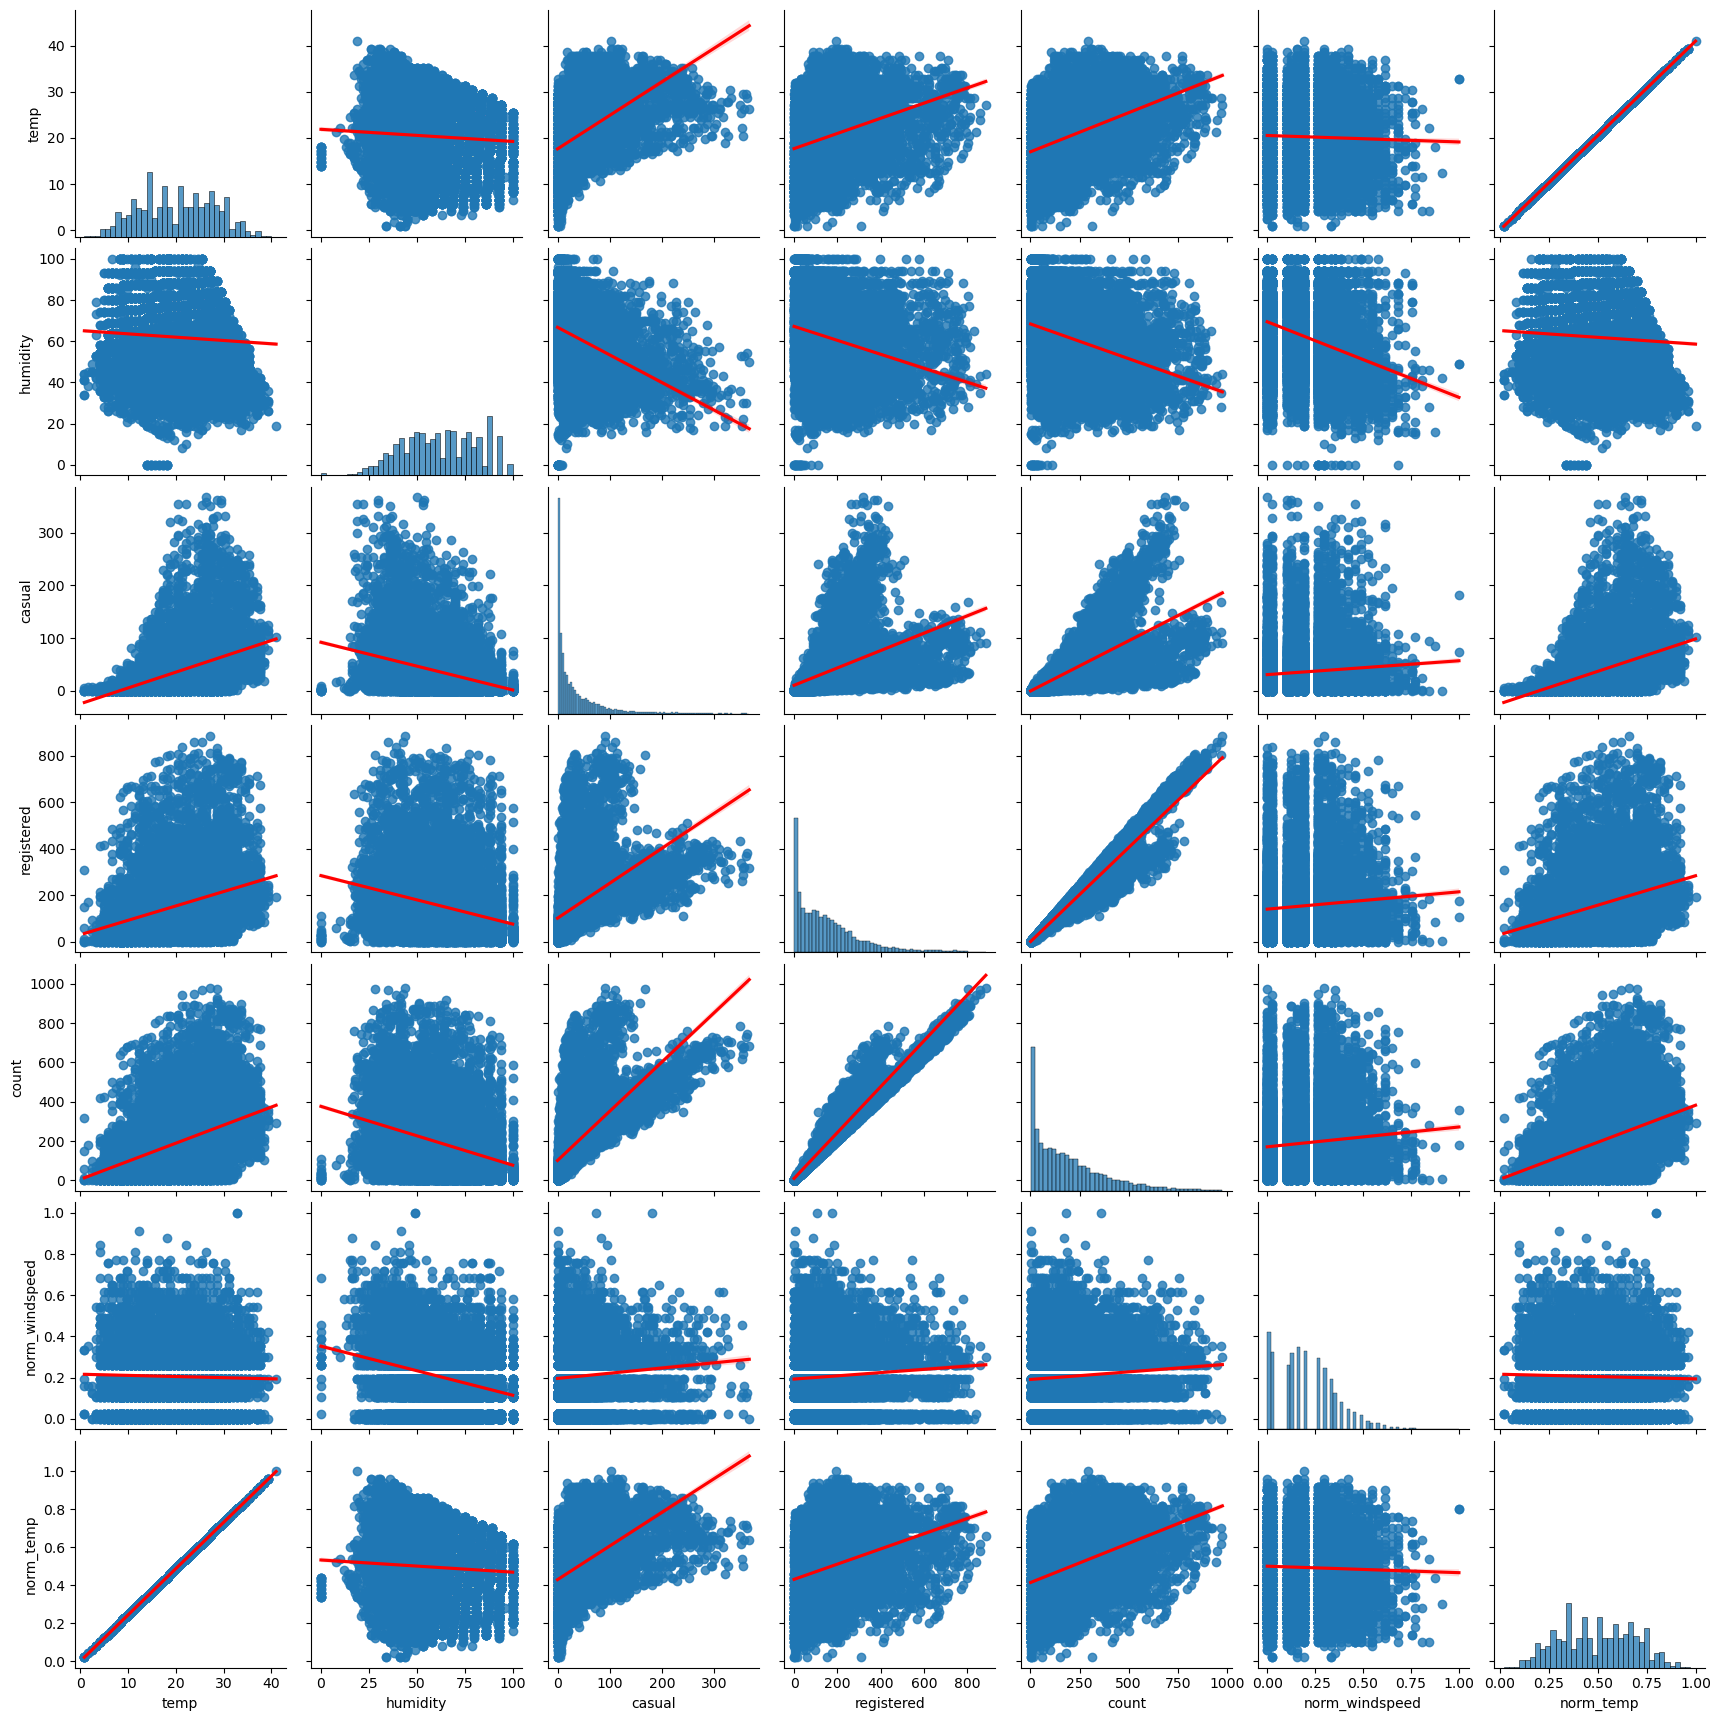

In [229]:
numeric_df = df.select_dtypes(include=[float, int])

sns.pairplot(numeric_df,
             kind= 'reg',
             plot_kws= {'line_kws': {'color':'red'}})

Com base na visualização criada, é importante reiterar:
* **Variáveis Compostas**: as variáveis `registered` e `casual` são a composição da variável `count`. É esperado que haja uma alta correlação linear entre essas variáveis, uma vez que a soma de ambas resulta em `count`.
* **Variáveis Normalizadas**: as variáveis com prefixo *norm* são versões normalizadas de outras variáveis. É esperado que haja uma correlação linear perfeita (coeficiente de correlação igual a 1) entre uma variável normalizada e sua versão original.

Considerando essas observações acima, **o coeficiente de Pearson é uma boa opção para medir a correlação entre as variáveis quantitativas e a variável `count`**. Muitas das relações são lineares ou aproximadamente lineares, e os dados não apresentam muitos outliers.

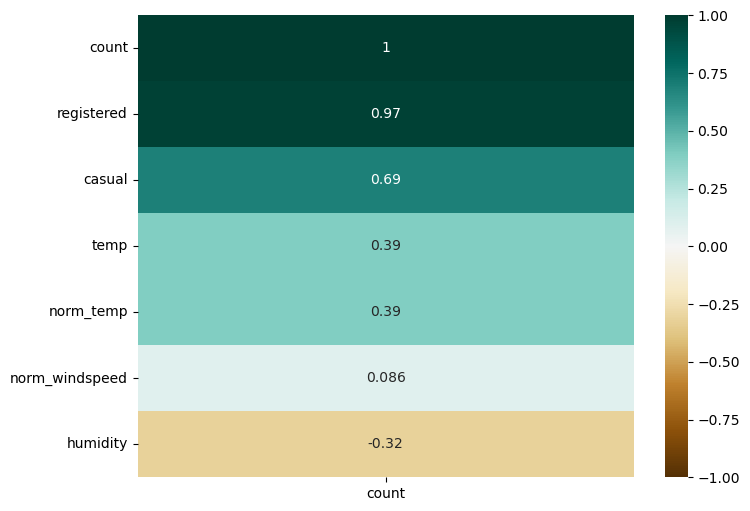

In [230]:
numeric_df = df.select_dtypes(include=[float, int])


plt.figure(figsize= (8, 6))

heatmap = sns.heatmap(numeric_df.corr(method= 'pearson')[['count']].sort_values(by='count', ascending= False),
                      vmin=-1,
                      vmax=1,
                      annot=True,
                      cmap='BrBG')

A partir do heatmap gerado, conseguimos definir as variáveis a serem analisadas. Consideramos que:

* **Correlação Alta**: valores entre ±0.50 e ±1 sugerem uma correlação forte entre as variáveis.
* **Correlação Moderada**: valores entre ±0.30 e ±0.49 sugerem uma correlação moderada entre as variáveis.
* **Correlação Baixa**: valores entre 0.29 e -0.29 são consideradas correlação baixa, onde valores muito próximos de zero implicam que **não há correlação entre as variáveis**.

Com base nisso, podemos afirmar que as variáveis que fazem sentido analisarmos o comportamento são:

* `temp` e `norm_temp`. que sugerem uma correlação moderada positiva. Isso sugere que, à medida que a temperatura aumenta, o número de alugueis de bicicleta tende a aumentar.
* `humidity`tem correlação negativa moderada, inficando que, à medida que a umidade aumenta, o número de aluguéis de bicicleta tende a diminuir ligeiramente.
* As variáveis `casual` e `registered` conforme falado acima, são a composição da variável `count`então era esperado uma correlação positiva alta. Conseguimos ver que os usuários registrados tem mais impacto no número de alugueis de bicicletas do que a variável `casual`, indicando que a maior parte de seus usuários são registrados no serviço.

Consideraremos que a variável `norm_windspeed` não tem impacto no número de aluguéis de bicicleta, uma vez que seu coeficiente de correlação é bem próximo de zero.

#### Variáveis Qualitativas

Para entender como as diferentes estações do ano, feriados, condições climáticas, meses, dias da semana e horários influenciam o número de aluguéis de bicicletas, vamos usar uma ferramenta estatística chamada Análise de Variância (ANOVA).

Se o p-valor for menor que 0.05, podemos concluir que existe uma diferença significativa entre as categorias da variável qualitativa e a quantidade de aluguéis de bicicleta. Ou seja, a variável influencia o aluguel de bicicletas.

Tecnicamente, se o p-valor da variável qualitativa for menor que 0.05, ela tem influência significativa na variável `count`. Um p-valor menor que 0.05 indica que é muito improvável que a diferença observada entre as categorias seja apenas por acaso. Ou seja, temos evidências estatísticas para afirmar que a variável em questão influencia significativamente o número de aluguéis."

In [261]:
anova_dict: dict = {}

for v in ['season', 'is_holiday', 'is_workingday', 'weather', 'month', 'weekday', 'hour']:
    p_value, eta_squared = run_anova(df, 'count', v)
    anova_dict[v] = {'p_value': p_value, 'eta_squared': eta_squared}
    print("\n")

ANOVA para season:
                  sum_sq       df           F         PR(>F)
C(season)  2.190083e+07      3.0  236.946711  6.164843e-149
Residual   3.352721e+08  10882.0         NaN            NaN
A variável season tem impacto significativo no número de aluguéis de bicicleta, pois o p-value é menor que 0.05.


ANOVA para is_holiday:
                      sum_sq       df         F    PR(>F)
C(is_holiday)  1.038812e+04      1.0  0.316563  0.573692
Residual       3.571625e+08  10884.0       NaN       NaN
A variável is_holiday não tem um impacto significativo no número de aluguéis de bicicleta, já que o p-value é maior que 0,05.


ANOVA para is_workingday:
                         sum_sq       df         F    PR(>F)
C(is_workingday)  4.801037e+04      1.0  1.463199  0.226448
Residual          3.571249e+08  10884.0       NaN       NaN
A variável is_workingday não tem um impacto significativo no número de aluguéis de bicicleta, já que o p-value é maior que 0,05.


ANOVA para weather:
    

Utilizando ANOVA, conseguimos identificar quais são as variáveis que tem impacto no número de bicicletas alugadas. Elas são: `season`, `weather`, `month` e `hour`. As variáveis `is_holiday`, `is_workingday` e `weekday` não tem impacto significativo no número de bicicletas alugadas.

Agora, para medir o tamanho do impacto das variáveis no número de bicicletas alugadas, nós utilizamos a medida chamada eta quadrado. Um eta-quadrado alto indica que a estação do ano explica uma grande parte da variabilidade nos aluguéis. Consideramos que:
* **eta-quadrado maior ou igual a 0.14** tem influência grande.
* **eta-quadrado menor que 0.14 e maior ou igual a 0.06** tem influência moderada.
* **eta-quadrado menor que 0.06 e maior ou igual a 0.01** tem influência baixa.

In [262]:
# Criando um DataFrame a partir do dicionário
anova_df = pd.DataFrame.from_dict(anova_dict, orient='index')
anova_df = anova_df.reset_index()
anova_df.rename(columns={'index': 'variavel'}, inplace=True)
anova_df = anova_df[anova_df['p_value'] < 0.05]
anova_df = anova_df.sort_values(by='eta_squared', ascending=False)

anova_df

,variavel,p_value,eta_squared
6,hour,0.000000e+00,0.516651
4,month,3.967012e-171,0.073553
0,season,6.164843e-149,0.061317
3,weather,5.482069e-42,0.017745


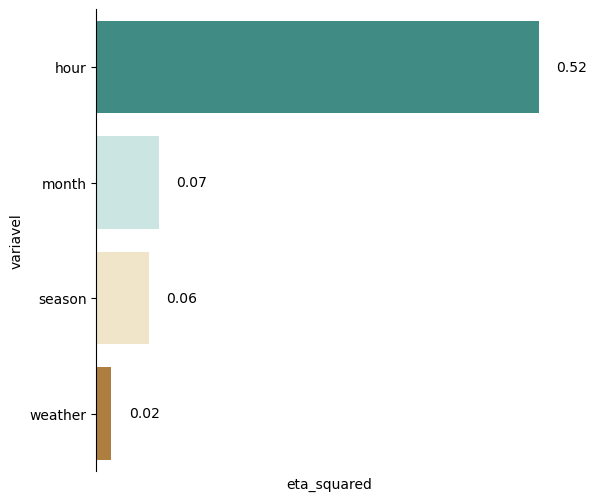

In [263]:
# Criar o gráfico de barras
fig,ax = plt.subplots(figsize=(6,6))

ax = sns.barplot(
    x='eta_squared',
    y='variavel',
    data=anova_df,
    orient='h',
    palette='BrBG_r'
)

# Removendo todos os elementos do eixo x
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_xticklabels([])

# Adicionando os valores nas barras
for p in ax.patches:
    width = p.get_width()
    plt.text(
        width + 0.02,
        p.get_y() + p.get_height() / 2,
        '{:.2f}'.format(width),
        ha='left',
        va='center')

# Removendo os o enquadramento
sns.despine(bottom=True);


Podemos afirmar que:
* A variável `hour` tem **impacto grande** no número de bicicletas alugadas. Isso indica que a hora do dia é um fator extremamente importante para explicar as variações no número de aluguéis.
* As variáveis `month` e `season` tem **impacto moderado** no número de bicicletas alugadas, o que mostra que o mês e a estação do ano também tem influência, porém com menor intensidade que a hora.
* A variável `weather` tem **impacto pequeno** no número de aluguéis. Isso indica que o clima, embora tenha alguma influência, é um fator menos importante em comparação com a hora, mês e estação do ano.

#### Resumo

Agora que calculamos quais fatores tem impacto no número de aluguéis, vamos elenca-las. Em ordem de maior impacto para menor impacto, seguem quais são as variáveis:

**Impacto Grande**
* **1. Usuário**: As variáveis `casual`e `registered` tem um forte e esperado impacto na variável `count`, uma vez que são a composição do KPI. Usuários registrados tem mais impacto que usuários casuais.
* **2. Hora**: a hora do dia tem um impacto **muito grande** no número de aluguéis de bicicleta.

**Impacto Moderado**
* **3. Temperatura**: a temperatura tem um impacto moderado positivo nos aluguéis de bicicleta. À medida que a temperatura aumenta, o número de aluguéis tende a aumentar.
* **4. Mês**: o mês do ano tem impacto moderado nos aluguéis de bicicleta.
* **5. Umidade**: a umidade do ar tem impacto moderado negativo nos aluguéis de bicicleta. À medida que a umidade do ar aumenta, o número de aluguéis de bicicleta tende a diminuir.
* **6. Estação do Ano**: a estação do ano tem impacto moderado nos aluguéis de bicicleta.

**Impacto Pequeno**
* **7. Clima**: o clima tem impacto pequeno nos aluguéis de bicicleta.

As variáveis `is_holiday`, `is_workingday` e `weekday` não tem impacto significativo no número de aluguel de bicicletas. Podemos inferir a partir disso que a condição do dia (Dia de semana, final de semana e feriado) não é um fator de impacto no número de aluguéis de bicicleta.

A variável `norm_windspeed` também teve um coeficiente de correlação muito baixo, indicando que também não é a velocidade do vento não é um fator de impacto na quantidade de bicicletas alugadas.

As unidades de medidas entre os dois métodos de associação são diferentes, então o ranqueamento de importância foi feito através de interpretação contextual.


## Análise dos Dados

### Preparação

Com as variáveis que impactam a quantidade de aluguéis de bicicletas mapeadas, vamos exportar o dataset limpo em `csv`, e importa-lo ao `Google Sheets`, para me seguida conectar o dataset ao `Looker Studio`.

No Looker Studio, constuiremos visualizações que vão nos ajudar a retirar insights sobre a quantidade de aluguéis de bicicleta e as variáveis que impactam esse **KPI**.

Nesta análise, priorizaremos **as variáveis que impactam diretamente o número de bicicletas alugadas**, com possíveis exceções para composição de alguma análise. Neste contexto, dividiremos a análise em categorias, de maneira que isso nos ajude a formular questões:

* **Comportamento de Usuário**: Com isso, entenderemos como é o comportamento do usuário do serviço.
    * Qual é a frequência com que os usuários alugam bicicletas?
    * Existe um perfil de usuário que aluga com mais frequência?

* **Tempo**: Isso nos ajudará a responder questões relacionadas a tempo e tendências.
    * Algum período do ano apresenta número maior de aluguéis?
    * Existem picos de aluguéis em horários específicos, como durante o horário de almoço ou após o expediente?

* **Clima**: Isso nos ajudará a entender como as condições climáticas influênciam a decisão dos usuários em alugar bicicletas.
    * Qual é a temperatura ideal para que haja um maior número de aluguéis?
    * Existe uma temperatura limite acima ou abaixo da qual a demanda diminui significativamente?
    * Qual é a umidade do ar ideal para que haja um maior número de aluguéis?
    * Existe algum padrão sazonal relacionado as estações do ano?

Exportação do dataset limpo:

In [260]:
df.to_csv("data/cleaned_bike_rental.csv", index= False)

### Insights

1. A quantidade média de aluguéis por hora é de 191. O alto desvio padrão de 181 indica que os dados variam bastante.
2. A média de aluguéis por hora de usuários casuais é de 36, enquanto a de usuários registrados é de 155. Isso indica que usuários registrados são os usuários mais frequêntes.